In [1]:
# 使用jupyter notebook 要加：
%matplotlib inline

import requests
import pandas as pd
import json
import numpy as np
# conda install seaborn
import seaborn as sns

In [2]:
# 用function將程式碼打包，方便我們多次使用，這行的意思就是宣告一個可呼叫的程式區塊，叫做crawl_price(stock_id)
def crawl_price(stock_id):

    url = "https://query1.finance.yahoo.com/v8/finance/chart/"+stock_id+"?period1=0&period2=1549258857&interval=1d&events=history&=hP2rOschxO0"

    res = requests.get(url)
    data = json.loads(res.text)
# 用dataframe取股價各值
    df = pd.DataFrame(data['chart']['result'][0]['indicators']['quote'][0], index=pd.to_datetime(data['chart']['result'][0]['timestamp'],unit='s'), columns=['open','high','low','close','volume'])
# 將小時拔掉！！！！！！！！！！！我debug de了3小時，注意看
    df.index=df.index.normalize()
# 日期索引值欄位名稱設定
    df=df.rename_axis("Date")
    # df.index.dt.strftime('%y-%m-%d')
# 開高低收設定
    # df=df.rename_axis("stock_price", axis="columns")
    return df


In [3]:
# 1.爬蟲國際股市
url = "https://finance.yahoo.com/world-indices/"
response = requests.get(url)

import io
# 2.用IO表示虛擬EXCEL檔案，建立國際股市對照表
f = io.StringIO(response.text)
dfs = pd.read_html(f)
world_index = dfs[0]

In [4]:
# 抓取全球指數
import time
world_index_history = {}
# 3.用國際股市對照表建立個股江波圖
for symbol, name in zip(world_index['Symbol'], world_index['Name']):  
    # print(name)  
    world_index_history[name] = crawl_price(symbol)
    # time.sleep(1)

KeyError: 'timestamp'

In [20]:
# 4.多股收盤價表
close = {}
for name, price in world_index_history.items():
    if price.index.is_unique:
        close[name] = price['close']
    
close = pd.DataFrame(close)

# 5.算獲利=>sharpe ratio
pct_change = close.pct_change()
profit = pct_change.mean()
risk = pct_change.std()

sharpe = profit / risk * (252 ** 0.5)
sharpe.sort_values()

ESTX 50 PR.EUR               0.013189
EURONEXT 100                 0.088551
TSEC weighted index          0.117173
FTSE Bursa Malaysia KLCI     0.177477
SSE Composite Index          0.242391
CAC 40                       0.242521
Cboe UK 100 Price Return     0.245896
BEL 20                       0.273527
KOSPI Composite Index        0.284806
STI Index                    0.293466
Nikkei 225                   0.295419
FTSE 100                     0.372016
HANG SENG INDEX              0.380929
S&P/ASX 200                  0.386850
Russell 2000                 0.400770
S&P/TSX Composite index      0.415661
DAX PERFORMANCE-INDEX        0.416142
Jakarta Composite Index      0.424039
NYSE AMEX COMPOSITE INDEX    0.429400
ALL ORDINARIES               0.437386
NYSE COMPOSITE (DJ)          0.438850
TA-125                       0.449807
Vix                          0.456238
S&P 500                      0.458898
S&P BSE SENSEX               0.482794
Nasdaq                       0.515188
Dow 30      

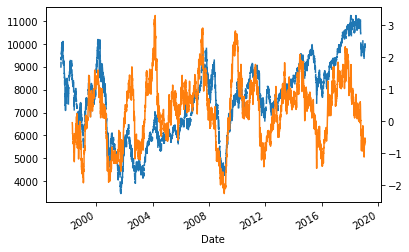

In [21]:
# 6.每日sharpe ratio，可看到sharpe ratio領先台灣加權指數
profit = pct_change.rolling(252).mean()
risk = pct_change.rolling(252).std()
sharpe = profit / risk * (252 ** 0.5)


close['TSEC weighted index'].plot()
sharpe['TSEC weighted index'].plot(secondary_y=True)